In [131]:
from pystock.portfolio import Portfolio, Stock
from pystock.models import Model
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pio.renderers.default = "notebook"
pio.templates.default = "plotly_dark"

import warnings

warnings.filterwarnings('ignore')

In [132]:
stock_dir = "Data/Stocks/nasdaq200"
index_dir = "Data/Indices"

In [133]:
apple = Stock(directory=os.path.join(stock_dir, "AAPL.csv"), name="Apple")
google = Stock(directory=os.path.join(stock_dir, "GOOG.csv"), name="Google")
tesla = Stock(directory=os.path.join(stock_dir, "TSLA.csv"), name="Tesla")
microsoft = Stock(directory=os.path.join(stock_dir, "MSFT.csv"), name="Microsoft")

In [134]:
stocks = [apple, google, tesla, microsoft]
benchmark_dir = os.path.join(index_dir, "GSPC.csv")
p = Portfolio(benchmark_dir=benchmark_dir, benchmark_name="S&P 500")

In [135]:
p.add_stocks(stocks)

In [136]:
start_date = "2012-01-01"
end_date = "2022-12-01"
freq = "M"
p.load_all(start_date=start_date, end_date=end_date, frequency=freq, columns=["Adj Close"], rename_cols=["Close"])

In [137]:
p.load_benchmark(start_date=start_date, end_date=end_date, frequency=freq, columns=["Close"], rename_cols=["Close"])

In [138]:
for stock, name in p:
    print(stock.loaded, name)

True S&P 500
True Apple
True Google
True Tesla
True Microsoft


In [139]:
p.summary(frequency="M")

Portfolio Summary
*****************

Portfolio with benchmark S&P 500 and stocks ['Apple', 'Google', 'Tesla', 'Microsoft']
Here are the summary of stocks in the portfolio
+----+-----------+-----------------------+----------------------+------------+----------+----------+
|    | Stock     |   Monthly_Mean_Return |   Monthly_Return_STD |      Alpha |     Beta |   Weight |
|----+-----------+-----------------------+----------------------+------------+----------+----------|
|  0 | Apple     |             0.0222202 |             0.128892 | 0.008545   | 1.22705  |     0.25 |
|  1 | Google    |             0.020647  |             0.088315 | 0.00711404 | 1.04298  |     0.25 |
|  2 | Tesla     |             0.0468996 |             0.182335 | 0.0336704  | 1.72526  |     0.25 |
|  3 | Microsoft |             0.0235556 |             0.095769 | 0.010973   | 0.964346 |     0.25 |
+----+-----------+-----------------------+----------------------+------------+----------+----------+
The covariance matrix

In [140]:
p.calculate_fff_params(frequency="M", factors=5, directory='.')

Frequency of stock stock and fama french factors are not equal. Equating frequencies... to D and M respectively.
Frequency of stock stock and fama french factors are not equal. Equating frequencies... to D and M respectively.
Frequency of stock stock and fama french factors are not equal. Equating frequencies... to D and M respectively.
Frequency of stock stock and fama french factors are not equal. Equating frequencies... to D and M respectively.
Done. Here are the parameters
+------------+------------+------------+-------------+
|      Apple |     Google |      Tesla |   Microsoft |
|------------+------------+------------+-------------|
|  0.0143852 |  0.0125203 |  0.0327456 |   0.0161275 |
|  1.15892   |  1.07649   |  1.42171   |   1.08658   |
|  0.332433  | -0.415644  |  0.30065   |  -0.262305  |
| -0.623922  | -0.0513299 | -0.786881  |  -0.455826  |
|  0.235985  |  0.0152995 | -0.572664  |   0.215502  |
| -0.757484  | -0.929504  | -0.746233  |  -0.771654  |
|  1         |  1      

In [141]:
m = Model("M")

In [142]:
m.add_portfolio(p, weights=[0.25, 0.25, 0.25, 0.25])

Adding portfolio...
Portfolio Summary
*****************

Portfolio with benchmark S&P 500 and stocks ['Apple', 'Google', 'Tesla', 'Microsoft']
Here are the summary of stocks in the portfolio
+----+-----------+-----------------------+----------------------+------------+----------+----------+
|    | Stock     |   Monthly_Mean_Return |   Monthly_Return_STD |      Alpha |     Beta |   Weight |
|----+-----------+-----------------------+----------------------+------------+----------+----------|
|  0 | Apple     |             0.0222202 |             0.128892 | 0.008545   | 1.22705  |     0.25 |
|  1 | Google    |             0.020647  |             0.088315 | 0.00711404 | 1.04298  |     0.25 |
|  2 | Tesla     |             0.0468996 |             0.182335 | 0.0336704  | 1.72526  |     0.25 |
|  3 | Microsoft |             0.0235556 |             0.095769 | 0.010973   | 0.964346 |     0.25 |
+----+-----------+-----------------------+----------------------+------------+----------+----------+
T

In [143]:
risk_free_rate = m.get_risk_free_rate()
risk_free_rate

0.3333333333333333

In [144]:
size = 20000
required_size = 8000
weights = np.random.uniform(low=-1.0, high=1.0,size=(size, len(m.portfolio)-1))
weights /= np.sum(weights, axis=1)[:, np.newaxis]
# weights = np.hstack((weights, np.ones((size, 1))))
weights.clip(min=-1, max=1, out=weights)
weights = weights[weights.sum(axis=1)==1]
if len(weights)<required_size:
    print("Not enough weights")
else:
    weights = weights[:required_size]
weights[0], len(weights)    

(array([ 0.17138396,  0.53028621, -0.15396326,  0.45229309]), 8000)

In [145]:
# required_size = 8000
# weights = np.random.uniform(low=0, high=1.0,size=(required_size, len(m.portfolio)-1))
# weights /= np.sum(weights, axis=1)[:, np.newaxis]
# weights.sum(axis=1)

In [146]:
returns = np.zeros(required_size)
volatilities = np.zeros(required_size)
sharpe_ratios = np.zeros(required_size)
for i in range(required_size):
    return_, variance, std = m.portfolio_info(weights[i], model="capm")
    returns[i] = return_
    volatilities[i] = variance
    sharpe_ratios[i] = (return_ - risk_free_rate) / std

In [147]:
tempelate = "Volatility deviation: %{x:.4f}%<br>Expected return: %{y:.4f}%"
for i, name in enumerate(m.portfolio.stock_names):
   tempelate+=f"<br>{name}: %{{customdata{[i]}:.4f}}%"

# print(tempelate)

In [148]:
fig = px.scatter(x=volatilities, y=returns, labels={"x": "Volatility", "y": "Return"}, custom_data=weights.T*100)
fig.update_traces(
    hovertemplate=tempelate,
    marker=dict(
        size=5,
        color=sharpe_ratios,
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title="Sharpe ratio"),
    ),
)
fig.show()

In [149]:
data = pd.DataFrame({"Volatility": volatilities, "Return": returns, "Sharpe ratio": sharpe_ratios})
data["Index"] = data.index
data.head()

Volatility    Return  Sharpe ratio  Index
0    0.712747  0.920104      0.695026      0
1    2.876828  1.408153      0.633693      1
2    0.546393  1.019357      0.928083      2
3    1.708822  0.871840      0.411948      3
4    0.958143  1.182817      0.867841      4

In [150]:
data["Return2"] = data["Return"].apply(lambda x: np.round(x, 3))
data.head()

Volatility    Return  Sharpe ratio  Index  Return2
0    0.712747  0.920104      0.695026      0    0.920
1    2.876828  1.408153      0.633693      1    1.408
2    0.546393  1.019357      0.928083      2    1.019
3    1.708822  0.871840      0.411948      3    0.872
4    0.958143  1.182817      0.867841      4    1.183

In [151]:
return_unique = data["Return2"].unique()
len(return_unique)

829

In [152]:
min_volatility = []
index = []
for i in return_unique:
    min_volatility.append(data[data["Return2"]==i]["Volatility"].min())
    index.append(data[data["Return2"]==i]["Volatility"].idxmin())

# for i in sharpe_ratios_unique:
#     min_volatility.append(data[data["Sharpe ratio2"]==i]["Volatility"].min())
#     index.append(data[data["Sharpe ratio2"]==i]["Volatility"].idxmin())

In [153]:
min_volatility = np.array(min_volatility)
index = np.array(index)
data_new = data.iloc[index]
data_new.head()

Volatility    Return  Sharpe ratio  Index  Return2
5281    0.651339  0.919720      0.726576   5281    0.920
6155    2.873417  1.408169      0.634078   6155    1.408
2       0.546393  1.019357      0.928083      2    1.019
2026    0.816732  0.871963      0.596006   2026    0.872
2862    0.952939  1.182694      0.870080   2862    1.183

In [154]:
data_new.sort_values(by="Return", inplace=True)

In [155]:
data_new["Return"].diff(1).max(), data_new["Return"].diff(1).min()

(0.02902792079572425, 5.9493224309647985e-05)

In [156]:
def remove_outliers(data, column):
    data = data.copy()
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)]
    return data

In [157]:
data_new["Return_Change"] = data_new["Return"].diff(1).fillna(0)
data_final = remove_outliers(data_new, "Return_Change")

In [158]:
from scipy.interpolate import interp1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

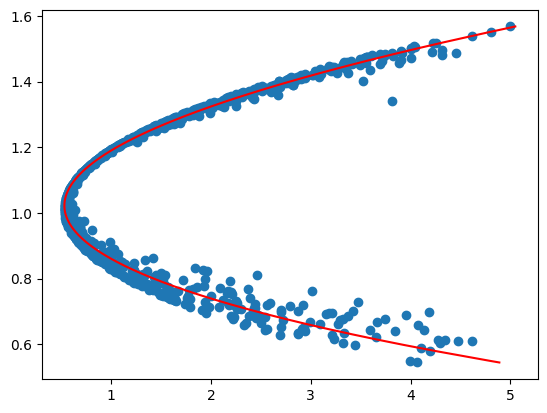

In [159]:
poly = PolynomialFeatures(3)
y = data_new["Volatility"].values
x = data_new["Return"].values
x_new = np.linspace(x.min(), x.max(), 200)
x_new = x_new.reshape(-1, 1)
x = x.reshape(-1, 1)
x_new_poly = poly.fit_transform(x_new)
x_poly = poly.fit_transform(x)
lr = LinearRegression()
lr.fit(x_poly, y)

y_new = lr.predict(x_poly)
y_new_new = lr.predict(x_new_poly)
# print
plt.scatter(y,x)
plt.plot(y_new, x, "r")
# plt.plot(y_new_new, x_new, "g")

In [160]:
len(x)

829

In [161]:
data_new["Final_Return"] = x
data_new["Final_Volatility"] = y_new
data_new.head()

Volatility    Return  Sharpe ratio  Index  Return2  Return_Change  \
2529    4.063576  0.544480      0.104744   2529    0.544       0.000000   
2090    3.998775  0.549066      0.107883   2090    0.549       0.004586   
3781    4.189740  0.578093      0.119577   3781    0.578       0.029028   
3224    4.107860  0.589665      0.126472   3224    0.590       0.011572   
7981    3.443215  0.597870      0.142562   7981    0.598       0.008205   

      Final_Return  Final_Volatility  
2529      0.544480          4.888935  
2090      0.549066          4.801741  
3781      0.578093          4.271841  
3224      0.589665          4.071143  
7981      0.597870          3.932447

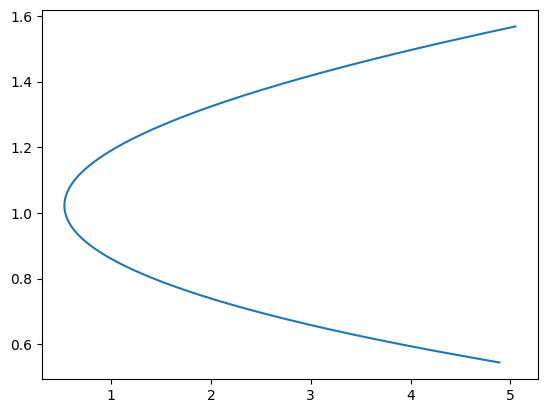

In [162]:
plt.plot(data_new["Final_Volatility"], data_new["Final_Return"])

In [163]:
weights_final = weights[index]

In [177]:
customdata = weights_final.T*100

In [164]:

fig = px.line(x=data_new["Final_Volatility"], y=data_new["Final_Return"], labels={"x": "Volatility", "y": "Return"}, custom_data=weights_final.T*100)
fig.update_traces(
    hovertemplate=tempelate,
    marker=dict(
        size=5,
        color=sharpe_ratios,
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title="Sharpe ratio"),
    ),
)
fig.show()

In [165]:
class CurveFitting:
    """
    A class to implement mth order polynomial regression using the least squares method.

    Use the `fit` method to fit the model. Then predict the Y values given X values using\\
    the `predict` method.

    """

    def __init__(self) -> None:
        self.beta = None
        self.stats = None

    def fit(self, X, Y, order=3, plot=False, stats=True):
        """
        Polynomial regression of order m using least squares method.

        Parameters
        ----------
        X : array_like
            Independent variable.
        Y : array_like
            Dependent variable.
        order : int, optional
            Order of the polynomial. Default is 3.
        plot : bool, optional
            If True, plot the regression line. Default is True.
        statistics : bool, optional
            If True, return the statistics. Default is True.

        Returns
        -------
        beta : array_like
            Coefficients of the polynomial regression model.
        stats : dict
            Statistics of the polynomial regression model.
            `r2` : square of correlation coefficient
            `syx` : standard error of the estimate
        """
        self.n = len(X)
        Xis = np.zeros(2 * order + 1)
        Yis = np.zeros(order + 1)
        for i in range(0, 2 * order + 1):
            if i == 0:
                Xis[i] = self.n
                continue
            xi = np.sum(X ** i)
            Xis[i] = xi

        for i in range(1, order + 2):
            yi = np.sum(Y * (X ** (i - 1)))
            Yis[i - 1] = yi
        A = np.zeros((order + 1, order + 1))
        for i in range(0, order + 1):
            A[i] = Xis[i : i + order + 1]
        beta = np.linalg.solve(A, Yis)
        self.beta = beta

        if plot:
            X_l = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

            def predict(X_l):
                Y_l = 0
                for i in range(0, order + 1):
                    Y_l += beta[i] * X_l ** i
                return Y_l

            Y_l = predict(X_l)
            plt.figure(figsize=(10, 8))
            plt.scatter(X, Y)
            plt.plot(X_l, Y_l, "r")
            plt.xlim(np.min(X) - np.std(X), np.max(X) + np.std(X))
            plt.ylim(np.min(Y) - np.std(Y), np.max(Y) + np.std(Y))
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.show()

        if stats:
            ymean = np.mean(Y)
            y_pred = self.predict(X)
            Sr = np.sum((Y - y_pred) ** 2)
            SYX = np.sqrt(Sr / (self.n - order - 1))
            # r2
            r2 = (np.sum((Y - ymean) ** 2) - Sr) / (np.sum((Y - ymean) ** 2))
            stats = {"r2": r2, "syx": SYX}
            self.stats = stats
            return beta, stats
        else:
            return beta

    def predict(self, X_l):
        """
        Predict the Y values given X values.

        Parameters
        ----------
        X_l : array_like
            Independent variable.

        Returns
        -------
        Y_l : array_like
            Predicted Y values.
        """
        Y_l = np.zeros(len(X_l))
        for i in range(0, len(self.beta)):
            Y_l += self.beta[i] * X_l ** i
        return Y_l

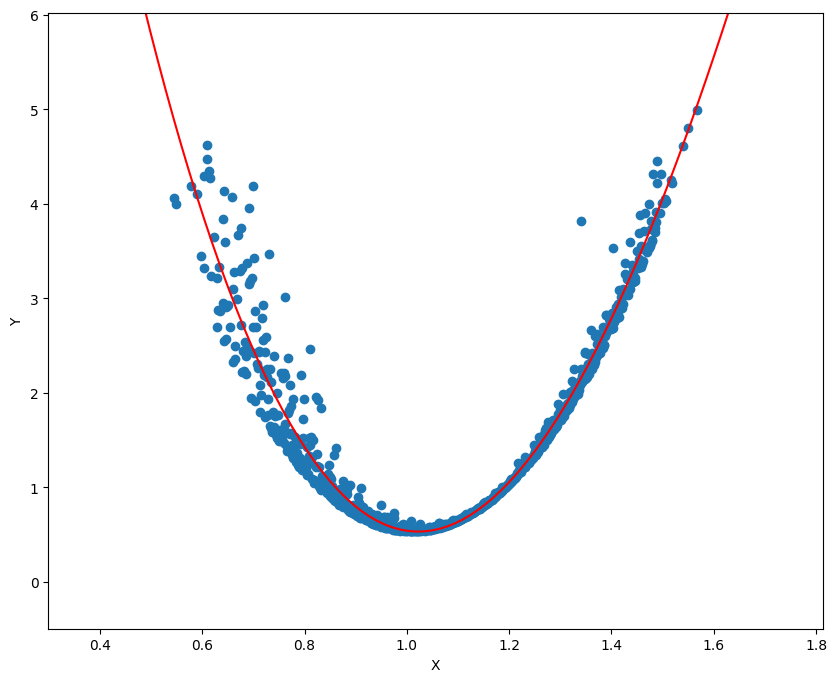

(array([ 22.6649157 , -47.31289079,  29.02229109,  -3.83459165]),
 {'r2': 0.9491666436202004, 'syx': 0.23268111311695652})

In [172]:
cf = CurveFitting()
cf.fit(Y=data_new["Volatility"], X=data_new["Return"], order=3, plot=True, stats=True)

In [173]:
cf.beta

array([ 22.6649157 , -47.31289079,  29.02229109,  -3.83459165])